In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()

        # FRONT-END (VGG16 layers)
        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True)
        )

        # BACK-END (Dilated CNN)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x


In [3]:
import numpy as np

IMG_PATH = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\images_npy\IMG_100_img.npy"   # change this
DEN_PATH = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\density_maps_npy\IMG_100_den.npy"  # change this

img = np.load(IMG_PATH)          # shape (3, 512, 512)
den = np.load(DEN_PATH)          # shape (512, 512)

img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # (1,3,H,W)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CSRNet().to(device)
model.eval()

with torch.no_grad():
    pred = model(img_tensor.to(device))

print("Input shape:", img_tensor.shape)
print("Output shape:", pred.shape)


Input shape: torch.Size([1, 3, 512, 512])
Output shape: torch.Size([1, 1, 64, 64])


Validation:   0%|          | 0/300 [00:00<?, ?it/s]

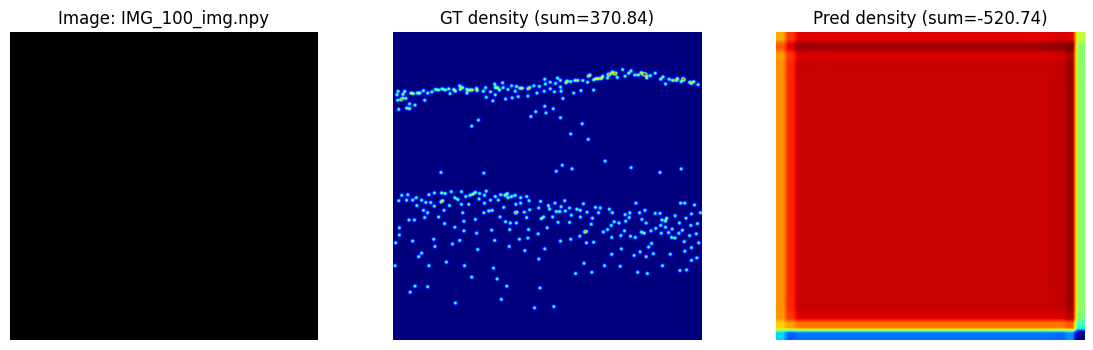

Validation:  25%|██▍       | 74/300 [03:58<11:06,  2.95s/it]

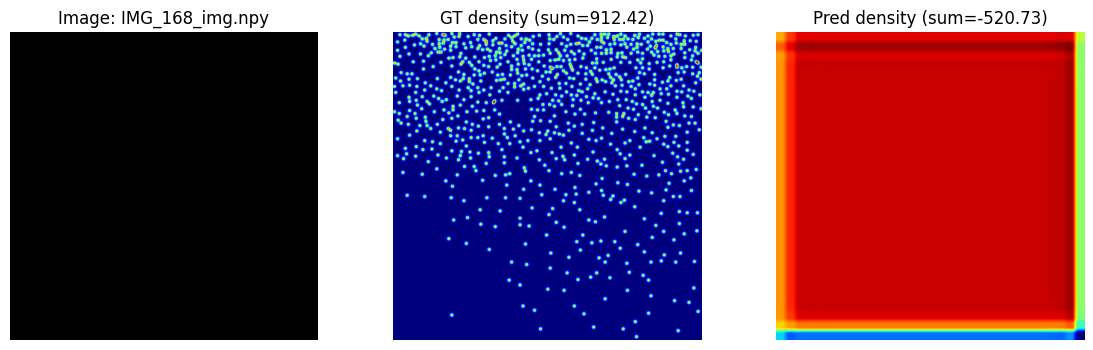

Validation:  50%|████▉     | 149/300 [07:44<07:18,  2.91s/it]

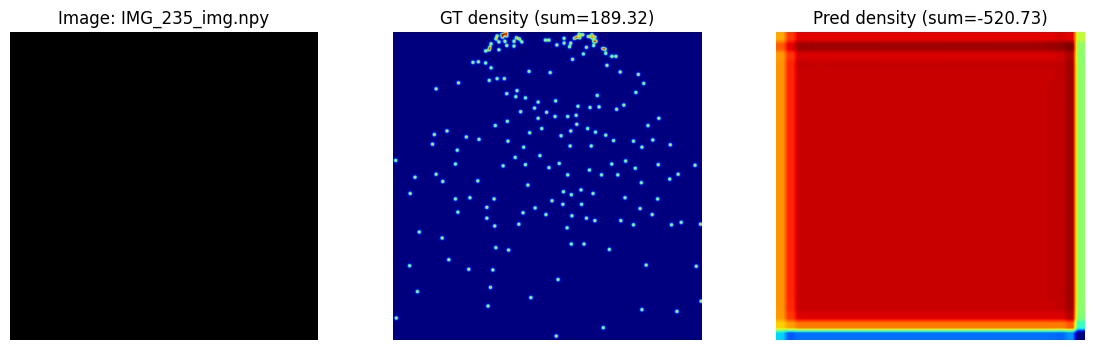

Validation:  75%|███████▍  | 224/300 [11:19<03:33,  2.81s/it]

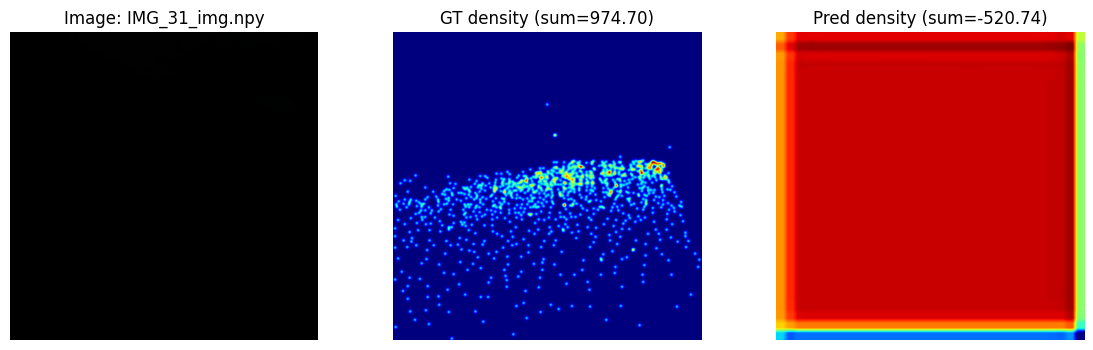

Validation: 100%|█████████▉| 299/300 [15:08<00:03,  3.03s/it]

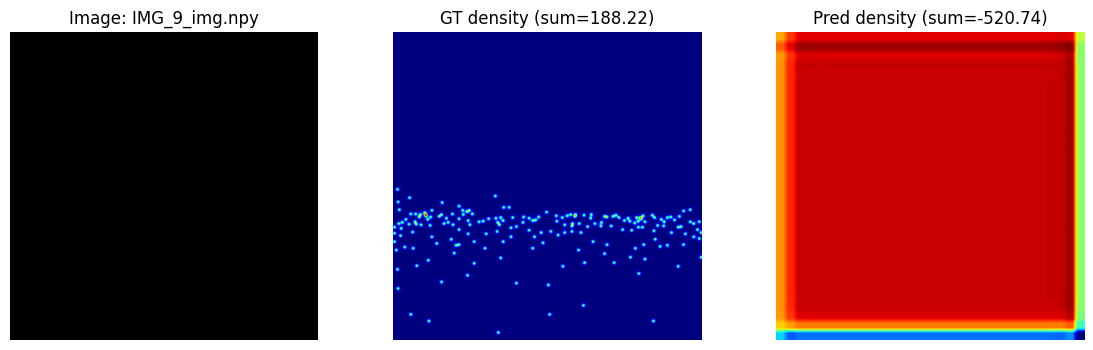

Validation: 100%|██████████| 300/300 [15:11<00:00,  3.04s/it]

Validation results over 300 samples — MAE: 1061.021, RMSE: 1174.278


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.eval()

# Paths (change as needed)
img_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\images_npy"
den_full_dir = r"C:\Users\sneha\.cache\kagglehub\datasets\tthien\shanghaitech\versions\1\ShanghaiTech\part_A\density_maps_npy"  # full-size GT (512x512)
# If your full GT arrays are named IMG_1_den.npy etc, adapt accordingly

def validate_and_visualize(model, img_dir, den_full_dir, device, n_examples=5):
    model.to(device)
    files = sorted([f for f in os.listdir(img_dir) if f.endswith("_img.npy")])
    maes = []
    rmses = []

    # pick some indices to visualize
    vis_idxs = np.linspace(0, len(files)-1, min(n_examples, len(files))).astype(int)

    for i, fname in enumerate(tqdm(files, desc="Validation")):
        img_path = os.path.join(img_dir, fname)
        den_full_name = fname.replace("_img.npy", "_den.npy")
        den_full_path = os.path.join(den_full_dir, den_full_name)

        img = np.load(img_path).astype(np.float32)      # (3,H,W)
        den_full = np.load(den_full_path).astype(np.float32)  # (H,W), original 512x512

        # prepare tensor
        img_t = torch.tensor(img).unsqueeze(0).to(device)  # (1,3,H,W)
        # forward
        with torch.no_grad():
            pred_small = model(img_t)  # (1,1,64,64)
            # upsample to original size for counting/visualization
            pred_full = F.interpolate(pred_small, size=den_full.shape, mode='bilinear', align_corners=False)
            pred_full = pred_full.squeeze().cpu().numpy()   # (H,W)

        # counts
        pred_count = pred_full.sum()
        gt_count = den_full.sum()
        maes.append(abs(pred_count - gt_count))
        rmses.append((pred_count - gt_count)**2)

        # visualize some examples
        if i in vis_idxs:
            img_vis = np.transpose(img, (1,2,0))  # H,W,3
            plt.figure(figsize=(14,4))
            plt.subplot(1,3,1)
            plt.imshow(img_vis/255.0)
            plt.title(f"Image: {fname}")
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(den_full, cmap='jet')
            plt.title(f"GT density (sum={gt_count:.2f})")
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(pred_full, cmap='jet')
            plt.title(f"Pred density (sum={pred_count:.2f})")
            plt.axis('off')
            plt.show()

    MAE = np.mean(maes)
    RMSE = np.sqrt(np.mean(rmses))
    print(f"Validation results over {len(files)} samples — MAE: {MAE:.3f}, RMSE: {RMSE:.3f}")
    return MAE, RMSE

# run validation
MAE, RMSE = validate_and_visualize(model, img_dir, den_full_dir, device, n_examples=5)
